In [31]:
import numpy as np
import cv2

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt

In [161]:
def showim(im):
    fig = plt.figure(figsize=(16,12))
    plt.imshow(im[:,:,::-1])
    plt.show()

In [162]:
img = cv2.imread('cat.jpg', cv2.IMREAD_UNCHANGED)

In [167]:
img = cv2.resize(img, (200, 128))

## Медианный фильтр с простой сортировкой


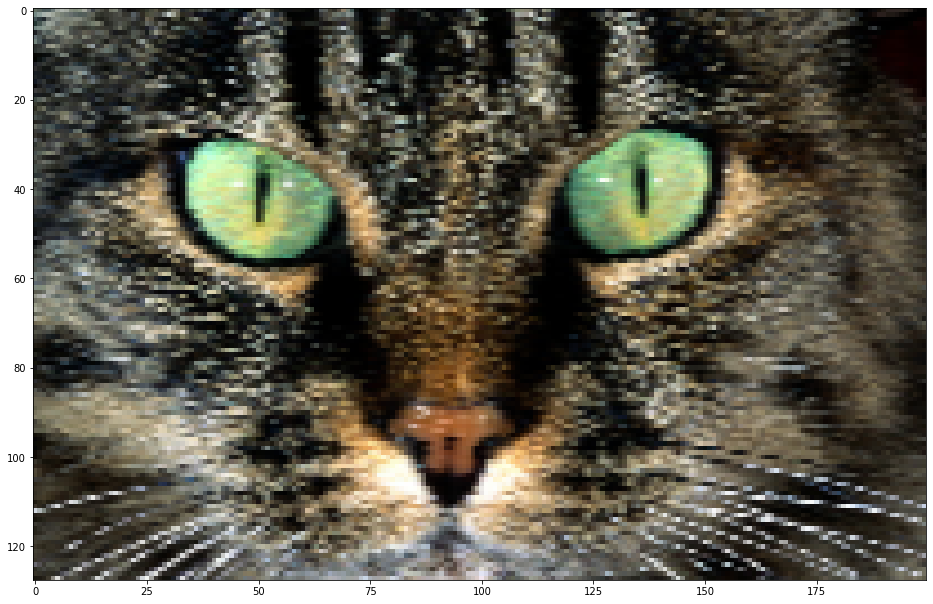

In [168]:
showim(img)

In [125]:
def med_blur_sort(img, wind_size):

    wind_i = int(wind_size / 2)
    wind_j = int(wind_size / 2)
    rang = int((2 * wind_i + 1) *(2* wind_j +1)/2)
    img_c = img.copy(img.shape)


    for i in range( wind_i, img.shape[0] - wind_i ):
        for j in range( wind_j, img.shape[1] - wind_j ):
            #print(img[i - wind_i: i + wind_i+1, j-wind_j : j + wind_j+1, 0])

            img_c[i][j][0] = np.sort(img[i - wind_i: i + wind_i+1, j-wind_j : j + wind_j+1, 0].flatten())[rang]
            img_c[i][j][1] = np.sort(img[i - wind_i: i + wind_i+1, j-wind_j : j + wind_j+1, 1].flatten())[rang]
            img_c[i][j][2] = np.sort(img[i - wind_i: i + wind_i+1, j-wind_j : j + wind_j+1, 2].flatten())[rang]
    return img_c

In [126]:
img_s = med_blur_sort(img, 5)

C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  


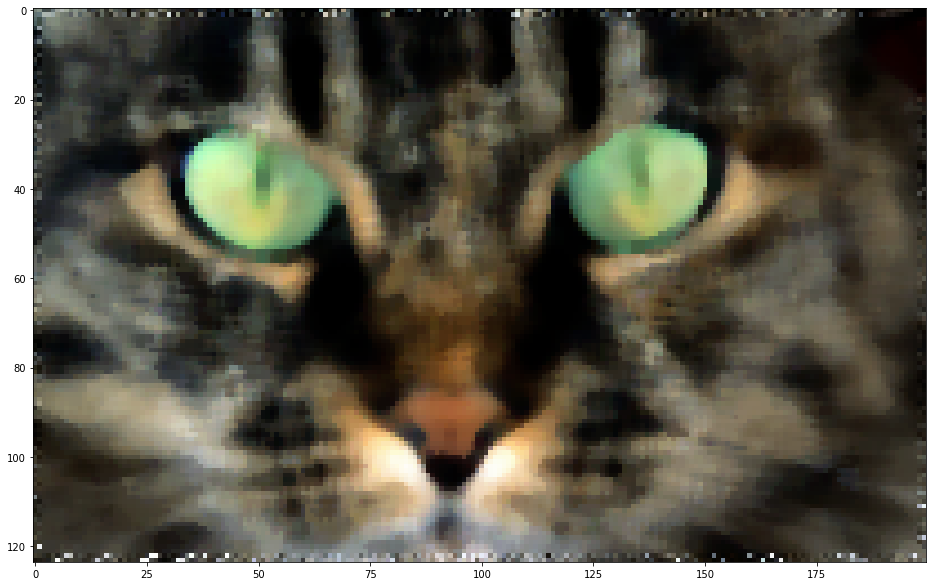

In [101]:
showim(img_s)

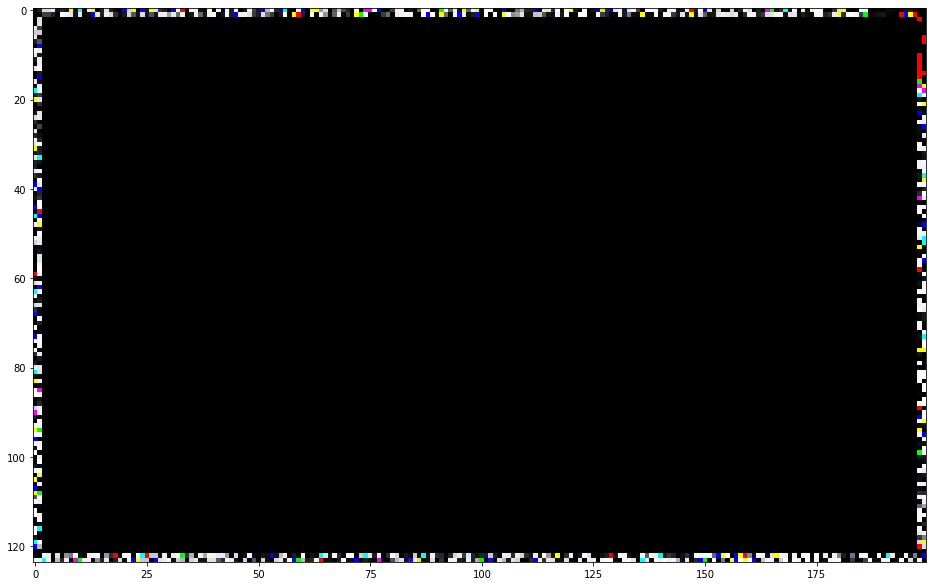

In [107]:
showim(img_s - cv2.medianBlur(img, 5))

Следовательно, не учитывая края, которые надо дополнять, этот алгоритм  работает так же, как и библиотечный

## Медианный фильтр Huang

In [52]:
class MedianBlur_huang:
    def __init__(self, wind_size):
        assert wind_size % 2 == 1
        self.wind_size = wind_size
        self.wind_i = wind_size // 2
        self.wind_j = wind_size // 2
        self.rang = wind_size * wind_size // 2
        
        
    def blure_image(self, img):
        self._prepare(img, self.wind_i)
        return self._blur(img)
        
    def _prepare(self, img, i):
        self.diagr = self._build_diagr(img, self.wind_size, i, self.wind_j, self.wind_i, self.wind_j)
        self.med = self._find_med(self.diagr, self.rang+1)
        self.sum_left = [np.sum(self.diagr[0:self.med[c],c]) for c in range(3)]
        self.sum_right = [np.sum(self.diagr[self.med[c]+1:,c]) for c in range(3)]
    
    def _clone_stats(self):
        self._last_row_diag = np.array(self.diagr.copy())
        self._last_row_med = np.array(self.med.copy())
        self._last_row_sum_left = np.array(self.sum_left.copy())
        self._last_row_sum_right = np.array(self.sum_right.copy()) 
        
    def _retore_stats(self):
        self.diagr = self._last_row_diag
        self.med = self._last_row_med
        self.sum_left = self._last_row_sum_left
        self.sum_right = self._last_row_sum_right
    
    def _blur(self, img):
        res = img.copy()
        for i in range(self.wind_i, img.shape[0]-self.wind_i):
#             self._prepare(img,i)
            if i > self.wind_i:
                self._retore_stats()
                self._assert_stats_correct()
                for k in range(self.wind_size):
                    for color in range(3):
                        droped_pixel = img[i - self.wind_i -1,k,color]
                        new_pixel = img[i + self.wind_i,k,color]
                        self._update_stats(droped_pixel,new_pixel,color)
                        self._assert_stats_correct()
            self._clone_stats()          
            res[i,self.wind_j] = self.med
            
            self._assert_stats_correct()

            for j in range(self.wind_j+1, img.shape[1]-self.wind_j):
                for k in range(-self.wind_i, self.wind_i+1):
                    for color in range(3):
                        droped_pixel = img[i + k,j -self.wind_j- 1,color]
                        new_pixel = img[i + k,j + self.wind_j,color]
                        self._update_stats(droped_pixel,new_pixel,color)
                        
                        self._assert_stats_correct()
                res[i,j]=self.med
                self._assert_stats_correct()
        return res
    
    
    def _update_stats(self,droped_pixel,new_pixel,color):
        assert self.diagr[droped_pixel][color] > 0
        self.diagr[droped_pixel][color]-=1
        self.diagr[new_pixel][color]+=1
        if droped_pixel < self.med[color]:
            self.sum_left[color] -= 1
        if droped_pixel > self.med[color]:
            self.sum_right[color] -= 1
        if new_pixel < self.med[color]:
            self.sum_left[color] += 1
        if new_pixel >  self.med[color]:
            self.sum_right[color] += 1

        if self.sum_right[color] > self.rang:
            s = self.med[color]
            self.sum_left[color] += self.diagr[s][color]
            s += 1
            while(self.diagr[s][color] == 0):
                s+=1
                assert s < 256
            self.med[color] = s
            self.sum_right[color] -= self.diagr[s][color]

        if self.sum_left[color] > self.rang:
            s = self.med[color]
            self.sum_right[color] += self.diagr[s][color]
            s-=1
            while(self.diagr[s][color] == 0):
                s-=1
                assert s>=0
            self.sum_left[color] -= self.diagr[s][color]
            self.med[color] = s
            
    def _assert_stats_correct(self):
        return

    
    def _build_diagr(self, img, wind_size, i_, j_, wind_i, wind_j):
        diagr = np.zeros((256,3) , int)
        for i in range( i_ - wind_i , i_ + wind_i+1):
            for j in range(j_ - wind_j , j_ + wind_j+1):
                for k in range(3):
                    diagr[img[i][j][k]][k]+=1
        return diagr
    
    def _find_med_component(self, diagr, rang, color):
        rg = 0
        for i in range(256):
            rg += diagr[i][color]

            if (rg>=rang):
                return i
        assert False

    def _find_med(self,diagr, rang):
        med_0 = self._find_med_component(diagr, rang, 0)
        med_1 = self._find_med_component(diagr, rang, 1)
        med_2 = self._find_med_component(diagr, rang, 2)

        return np.array([med_0, med_1, med_2])



In [102]:
m = MedianBlur_huang(5)
img_h = m.blure_image(img)

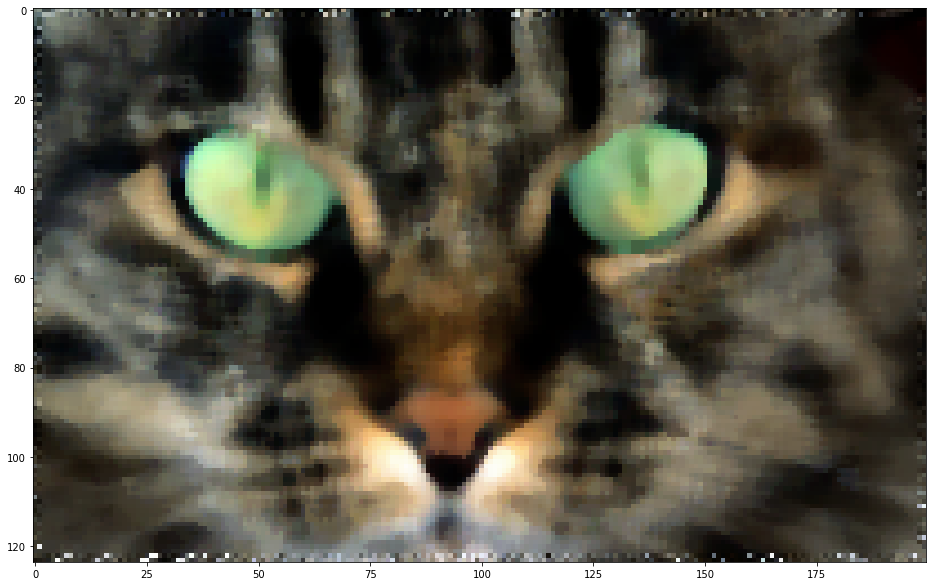

In [104]:
showim(img_h)

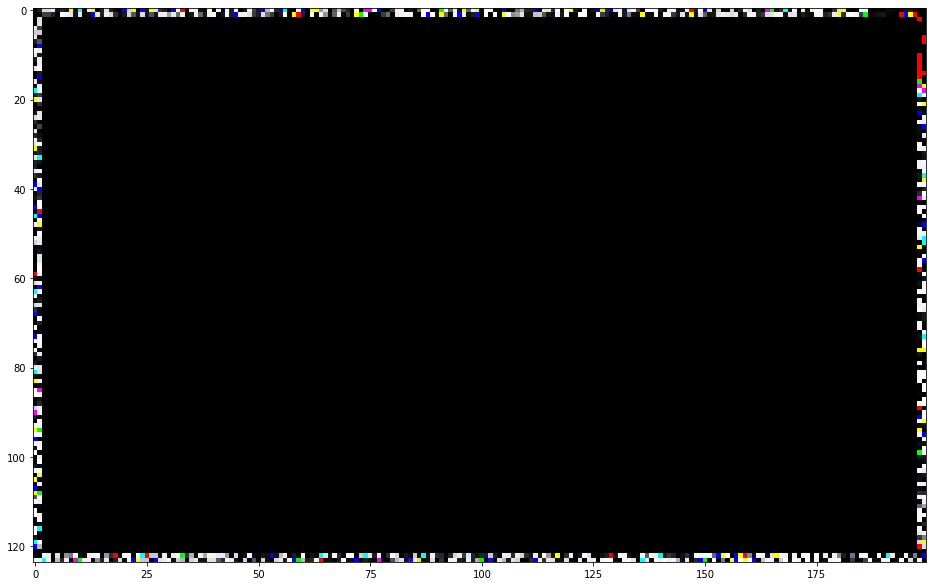

In [106]:
showim(img_h - cv2.medianBlur(img, 5))

Следовательно, не учитывая края, которые надо дополнять, этот алгоритм  работает так же, как и библиотечный

## Медианный фильтр за константное время

In [74]:
class Diagram:
    
    def _find_med(self):
            sz = self.diagr.sum(axis = 0)
            assert (sz[0] == sz[1] and sz[1] ==sz[2])
            sz = sz[0]
            rang = sz // 2 +1
            med_0 = self._find_med_component( rang, 0)
            med_1 = self._find_med_component( rang, 1)
            med_2 = self._find_med_component( rang, 2)
            self.med = np.array([med_0, med_1, med_2])
            return self.med

    def _find_med_component(self,  rang, color):
            rg  = 0
            for i in range(256):
                rg += self.diagr[i][color]

                if (rg>=rang):
                    return i
            #assert False



            
    def __init__(self, matrix):
        if matrix.shape == (256, 3):
            self.diagr = matrix.copy() 
        else:
            self.diagr = np.zeros((256,3) , int)
            
            for i in range( matrix.shape[0]):
                for j in range(matrix.shape[1]):
                    for k in range(3):
                        self.diagr[matrix[i][j][k]][k]+=1
                       
        self._find_med()
        
        
        
    def unite(self, diagr):
        return Diagram(self.diagr + diagr.diagr)
    
    def deite(self, diagr):
        return Diagram(self.diagr - diagr.diagr)
    

    def _update_stats(self,droped_pixel,new_pixel):
       
        for color in range(3):
            self.diagr[droped_pixel[color]][color]-=1
            self.diagr[new_pixel[color]][color]+=1
        self._find_med()

        


In [117]:
class MedianBlur_const:
    def __init__(self, wind_size):
        assert wind_size % 2 == 1
        self.wind_size = wind_size
        self.wind_i = wind_size // 2
        self.wind_j = wind_size // 2
        self.rang = (wind_size * wind_size) // 2 +1
        
        
    def blure_image(self, img):
        self._prepare(img)
        return self._blur(img)
        
    def _prepare(self, img):
        self.res = img.copy()
        self.diagr = Diagram(img[0 :self.wind_size, 0 : self.wind_size, :])
        self.start_diagr =self.diagr
        self.res[self.wind_i, self.wind_j, 0] = self.diagr.med[0]
        self.res[self.wind_i, self.wind_j, 1] = self.diagr.med[1]
        self.res[self.wind_i, self.wind_j, 2] = self.diagr.med[2] 
        self.rows = list()
        for j in range(img.shape[1]):    
            self.rows.append(Diagram(img[0:self.wind_size, j : j+1, :]))
        #for j in range(self.wind_j + 1, img.shape[1] - self.wind_j):
         #   self.res[self.wind_i, j] = ((self.diagr.unite(self.rows[j + self.wind_j])).deite(self.rows[j - self.wind_j - 1])).med
                
    
    
    
    def _blur(self, img):
        
        for i in range(self.wind_i + 1, img.shape[0]-self.wind_i):
                for j in range(img.shape[1]):
                    droped_pixel = img[i - self.wind_i -1,j]
                    new_pixel = img[i + self.wind_i,j ]
                    self.rows[j ]._update_stats(droped_pixel,new_pixel)
                self.diagr = (self.start_diagr.unite(Diagram(img[i + self.wind_i : i+self.wind_i +1, 0 : self.wind_size, :]))).deite(Diagram( img[i - self.wind_i - 1 : i - self.wind_i, 0 : self.wind_size, :]))
                self.start_diagr = self.diagr
                for j in range(self.wind_j + 1, img.shape[1] - self.wind_j):
                    self.diagr = (self.diagr.unite(self.rows[j + self.wind_j])).deite(self.rows[j - self.wind_j - 1])
                    self.res[i,j,0] =  self.diagr.med[0]   
                    self.res[i,j,1] =  self.diagr.med[1]   
                    self.res[i,j,2] =  self.diagr.med[2] 
        
                    
        return self.res
    
        

In [118]:
m = MedianBlur_const(5)
img_c = m.blure_image(img)

### результат работы

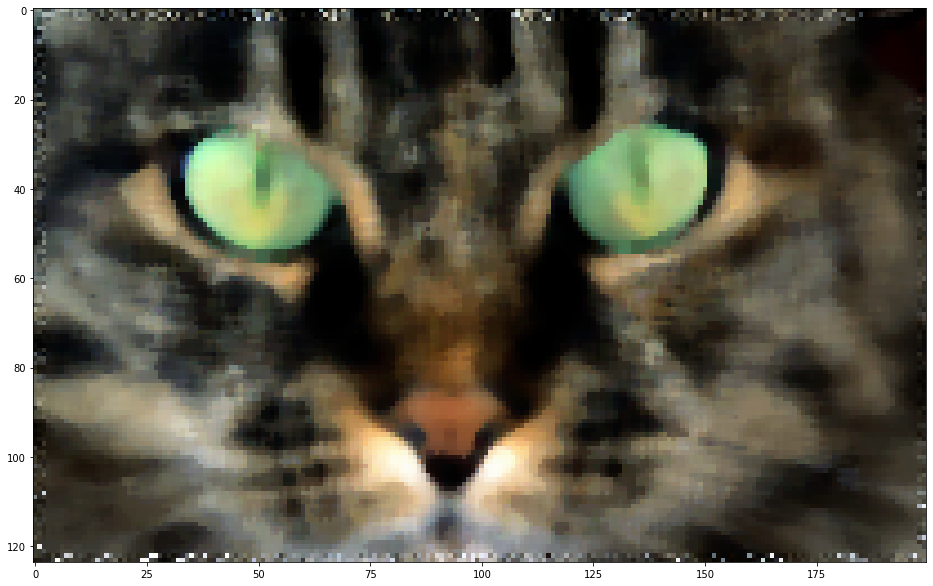

In [119]:
showim(img_c)

### результат работы библиотечной функции

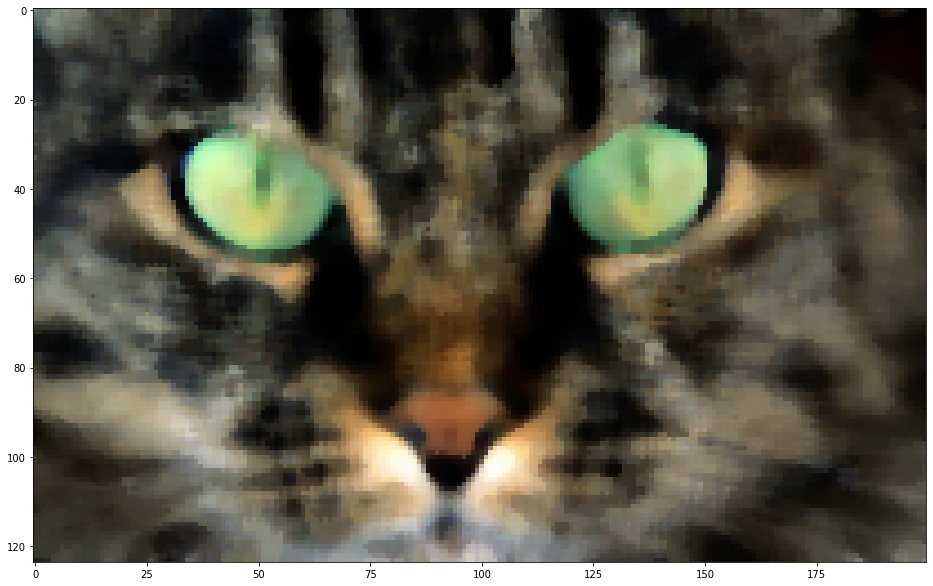

In [120]:
showim(cv2.medianBlur(img, 5))

посмотрим, как сильно они различаются

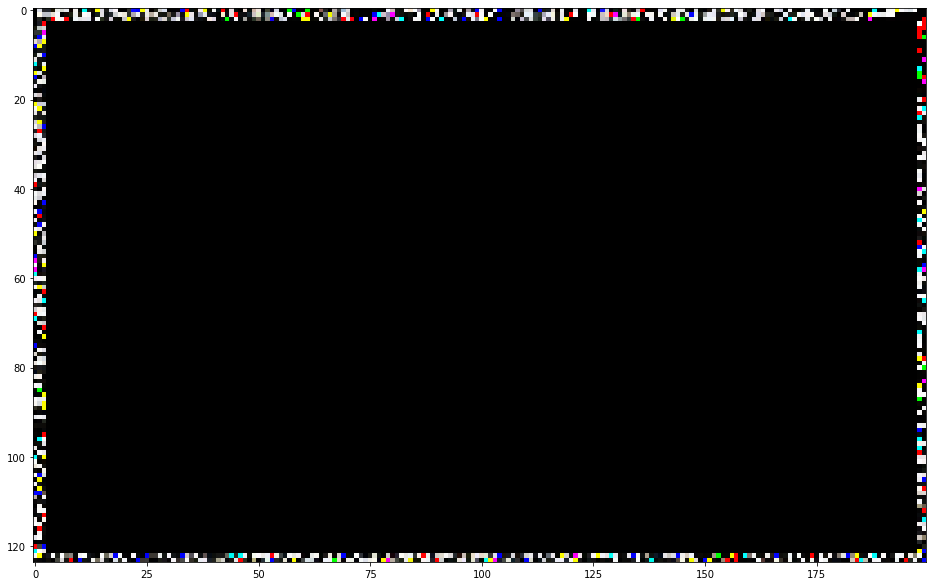

In [121]:
showim(cv2.medianBlur(img, 5) - img_c)

Следовательно, не учитывая края, которые надо дополнять, этот алгоритм работает так же, как и библиотечный

In [173]:
simp_wind_size = [3, 5, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

In [174]:
simp_wind_size

[3, 5, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101]

In [177]:
res_sort = []
for w_s in simp_wind_size:
    t0= time.clock() 
    med_blur_sort(img, w_s) 
    t1 = time.clock()
    res_sort.append(((t1 -  t0) * 1000)/ ((img.shape[0] - w_s + 1.)* (img.shape[1] - w_s + 1.)))
    

C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  
C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [178]:
res_huang = []
for w_s in simp_wind_size:
    t0= time.clock() 
    m = MedianBlur_huang(w_s)
    m.blure_image(img) 
    t1 = time.clock()
    res_huang.append(((t1 -  t0) * 1000)/ ((img.shape[0] - w_s + 1.)* (img.shape[1] - w_s + 1.)))
    

C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [179]:
res_const = []
for w_s in simp_wind_size:
    t0= time.clock() 
    m = MedianBlur_const(w_s)
    m.blure_image(img) 
    t1 = time.clock()
    res_const.append(((t1 -  t0) * 1000)/ ((img.shape[0] - w_s + 1.)* (img.shape[1] - w_s + 1.)))
    

C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\masha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


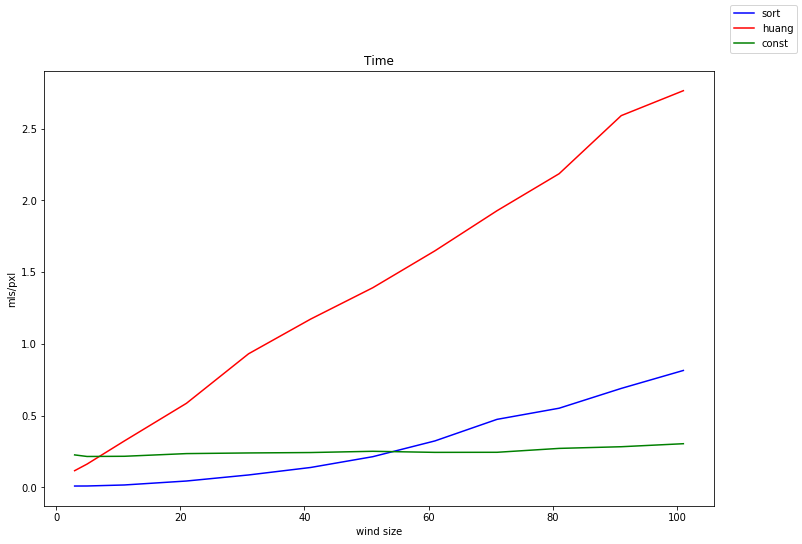

In [188]:
fig = plt.figure(figsize=(12, 8))
ax1 =  plt.plot(simp_wind_size, res_sort, color = 'b', label="sort")
ax2 = plt.plot(simp_wind_size, res_huang, color = 'r', label= 'huang')
ax3 = plt.plot(simp_wind_size, res_const, color = 'g', label= 'const')   
plt.title('Time')   
plt.ylabel('mls/pxl')   
plt.xlabel('wind size')   
  

fig.legend();
plt.show()   
